In [1]:
import pandas as pd
import numpy as np

In [2]:
# Load preference data
preference_df = pd.read_csv("synthetic-dataset/preference.csv")
user_item_matrix = preference_df.pivot(index='user_id', columns='activity_id', values='preference').fillna(0)

# Adjust preference values
user_item_matrix[user_item_matrix == -1] = np.nan

user_item_matrix.head()


activity_id,0,1,2,3,4,5,6,7,8,9,...,102,103,104,105,106,107,108,109,110,111
user_id,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,0.467129,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.032237,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,0.362345,NaN,NaN,NaN,NaN,0.979025,...,NaN,NaN,NaN,NaN,NaN,NaN,0.132707,NaN,NaN,NaN
2,NaN,0.947865,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.412991,NaN,0.399586,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,0.945527,NaN,NaN,NaN,...,NaN,0.469595,0.137711,NaN,NaN,NaN,0.193189,NaN,NaN,NaN
4,NaN,0.122903,0.452146,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.990753,NaN,NaN,NaN,0.974939,NaN,NaN,NaN


In [3]:
# see how cosine similarity works
from sklearn.metrics.pairwise import cosine_similarity
from scipy import spatial
import numpy as np

a = np.array([0, 2, 4])
b = np.array([1, 4, 2])
a = a -np.mean(a).repeat(len(a))
b = b - np.mean(b).repeat(len(b))
a = a / np.linalg.norm(a)
b = b / np.linalg.norm(b)
mat = np.stack((a, b), axis=0)

print(spatial.distance.cosine(a, b))
print(cosine_similarity(mat))

0.6726731646460115
[[1.         0.32732684]
 [0.32732684 1.        ]]


In [4]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error

# Load preference data
preference_df = pd.read_csv("synthetic-dataset/preference.csv")
user_item_matrix = preference_df.pivot(index='user_id', columns='activity_id', values='preference')

# Replace -1 with NaN to indicate missing data
user_item_matrix.replace(-1, np.nan, inplace=True)

# Fill NaN values with the mean of each user's preferences for the purpose of computing similarities
mean_user_preferences = user_item_matrix.mean(axis=1)
mean_user_preferences = mean_user_preferences.fillna(mean_user_preferences.mean())
user_item_matrix_filled = user_item_matrix.T.fillna(mean_user_preferences).T

# Compute cosine similarity between users
user_similarity_matrix = cosine_similarity(user_item_matrix_filled)

print("Dimensions of user similarity matrix:", user_similarity_matrix.shape)
print("Number of users:", user_similarity_matrix.shape[0])
print("Number of items:", user_item_matrix_filled.shape[1])
print("length of one row of user item matrix:", len(user_item_matrix_filled.iloc[0]))

# Function to predict preferences
def predict_preferences(user_id):
    # Weights are the similarities with other users
    weights = user_similarity_matrix[user_id]
    # Get the ratings from all users
    ratings = user_item_matrix_filled.values
    # Compute the weighted sum of ratings
    weighted_ratings = np.dot(weights, ratings)
    # Compute the sum of weights
    sum_of_weights = np.array([np.abs(weights).sum() for _ in range(ratings.shape[1])])
    # Predicted preferences
    predicted_preferences = weighted_ratings / sum_of_weights
    # Replace known values with original to not predict them
    predicted_preferences[user_item_matrix.iloc[user_id].notna().values] = user_item_matrix.iloc[user_id].values[user_item_matrix.iloc[user_id].notna().values]
    return predicted_preferences

# Example: predict preferences for user 0
predicted_preferences_user_0 = predict_preferences(0)
print("Predicted preferences for user 0:", predicted_preferences_user_0)


Dimensions of user similarity matrix: (50, 50)
Number of users: 50
Number of items: 112
length of one row of user item matrix: 112
Predicted preferences for user 0: [0.40096788 0.43504847 0.42062394 0.39735163 0.41409913 0.4671293
 0.42844352 0.41648886 0.39159219 0.42277709 0.42354304 0.42995743
 0.42693368 0.43964985 0.42974662 0.42299322 0.39058852 0.34748638
 0.43711889 0.43033181 0.42298422 0.42565464 0.40483332 0.43674444
 0.40960037 0.42499831 0.36133339 0.4324046  0.41301778 0.41346579
 0.7168039  0.41919052 0.44109384 0.42837728 0.39342592 0.42184039
 0.4044023  0.39695641 0.71507495 0.39861614 0.43212591 0.42253577
 0.43192204 0.27663036 0.43204495 0.4174741  0.41921652 0.43287905
 0.34128456 0.42230405 0.42478648 0.40094284 0.41753082 0.44234542
 0.45959583 0.42663837 0.40725242 0.44506997 0.41972025 0.42498317
 0.4430424  0.42543413 0.41573771 0.40884764 0.42384457 0.4120095
 0.43537013 0.42709261 0.41443393 0.43123971 0.43805804 0.08996806
 0.42335761 0.41829181 0.43250007

In [5]:
from sklearn.metrics import mean_squared_error

# Predict preferences for all user-item pairs
all_predictions = np.zeros_like(user_item_matrix.values)
for i in range(user_item_matrix.shape[0]):
    all_predictions[i, :] = predict_preferences(i)

# Calculate MSE
mse = mean_squared_error(user_item_matrix_filled.values.flatten(), all_predictions.flatten())
print("Mean Squared Error:", mse)


Mean Squared Error: 0.006918491668441829


### Make some analysis on the predictions

In [6]:
users = pd.read_csv("synthetic-dataset/user.csv")
activities = pd.read_csv("synthetic-dataset/activity.csv", sep='|')
user_id = np.random.choice(users['user_id'])
print("User ID:", user_id)

true_user_condition = users[users['user_id'] == user_id].values[0][1]
print("True user conditions:", true_user_condition)

predicted_preferences = predict_preferences(user_id)
print("Predicted preferences:", predicted_preferences)

# Find the top 5 activities with the highest predicted preferences
top_activities = np.argsort(predicted_preferences)[::-1][:5]
print("Top 5 activities:", top_activities)

# Get the target condition of the top activities
target_conditions = activities.loc[top_activities, 'target_condition'].values
print("Target conditions of top activities:", target_conditions)

User ID: 11
True user conditions: 2
Predicted preferences: [0.20992194 0.43475087 0.42053749 0.39756919 0.41398921 0.19465231
 0.42811549 0.41642746 0.39159714 0.42246205 0.42341625 0.42980807
 0.42684104 0.43910335 0.42977366 0.42339764 0.39077504 0.42885211
 0.43726042 0.43036773 0.4232313  0.42586449 0.40481375 0.43694426
 0.40961961 0.42494022 0.45844093 0.43230388 0.41296752 0.41340002
 0.41377314 0.41913808 0.44093915 0.42828048 0.39302185 0.42158089
 0.40424642 0.39689156 0.42905677 0.3988976  0.96533444 0.42279428
 0.4320966  0.39594543 0.43237278 0.41745025 0.41948778 0.43293755
 0.41069233 0.42224985 0.42462426 0.29438165 0.41756748 0.44215832
 0.45923879 0.42647296 0.40727123 0.48901155 0.4195299  0.36709273
 0.44289233 0.42530306 0.41558547 0.40899188 0.93207565 0.41240821
 0.43559998 0.42721696 0.41451318 0.43119219 0.43819573 0.44395988
 0.4233491  0.4182421  0.43256543 0.42169042 0.45592516 0.41526455
 0.40518898 0.41645389 0.93398262 0.41884586 0.41474067 0.40837674
 0.

In [7]:
# for each possible condition, we want to measure the accuracy of the predictions
# for users with that condition

def custom_accuracy(user, prediction):
    # Get the user's condition
    user_condition = users[users['user_id'] == user]['condition_id'].values[0]
    # Get the target condition of the top activities
    top_activities = np.argsort(prediction)[::-1][:5]
    target_conditions = activities.loc[top_activities, 'target_condition'].values
    # measure the accuracy by summing a coefficient for each suggestion, decreasing with the rank
    accuracy = 0
    for rk, condition in enumerate(target_conditions):
        if condition == user_condition:
            accuracy += 0.5 / 2**rk

    return accuracy

# Get the unique target conditions
unique_conditions = activities['target_condition'].unique()

# Initialize a dictionary to store the MSE for each condition
mse_by_condition = {condition: 0 for condition in unique_conditions}
accuracy_by_condition = {condition: 0 for condition in unique_conditions}

# Iterate over each condition
for condition in unique_conditions:
    # Get the user ids with the target condition
    user_ids = users[users['condition_id'] == condition]['user_id'].values
    # Calculate the MSE for the users with the target condition
    mse_by_condition[condition] = mean_squared_error(user_item_matrix_filled.loc[user_ids].values.flatten(), all_predictions[user_ids].flatten())
    # Calculate the accuracy for the users with the target condition
    for user_id in user_ids:
        accuracy_by_condition[condition] += custom_accuracy(user_id, all_predictions[user_id])
    # normalize the accuracy
    accuracy_by_condition[condition] /= len(user_ids)

print("MSE by condition:", mse_by_condition)
print("Accuracy by condition:", accuracy_by_condition)

MSE by condition: {0: 0.004630378764829178, 1: 0.006575722195933842, 2: 0.005803186872360702, 3: 0.010253235676736023}
Accuracy by condition: {0: 0.9232954545454546, 1: 0.9665178571428571, 2: 0.9505208333333334, 3: 0.7163461538461539}


0.6726731646460115
[[1.         0.32732684]
 [0.32732684 1.        ]]
Dimensions of user similarity matrix: (50, 50)
Number of users: 50
Number of items: 112
Length of one row of user item matrix: 112
Predicted preferences for user 0: [0.40096788 0.43504847 0.42062394 0.39735163 0.41409913 0.4671293
 0.42844352 0.41648886 0.39159219 0.42277709 0.42354304 0.42995743
 0.42693368 0.43964985 0.42974662 0.42299322 0.39058852 0.34748638
 0.43711889 0.43033181 0.42298422 0.42565464 0.40483332 0.43674444
 0.40960037 0.42499831 0.36133339 0.4324046  0.41301778 0.41346579
 0.7168039  0.41919052 0.44109384 0.42837728 0.39342592 0.42184039
 0.4044023  0.39695641 0.71507495 0.39861614 0.43212591 0.42253577
 0.43192204 0.27663036 0.43204495 0.4174741  0.41921652 0.43287905
 0.34128456 0.42230405 0.42478648 0.40094284 0.41753082 0.44234542
 0.45959583 0.42663837 0.40725242 0.44506997 0.41972025 0.42498317
 0.4430424  0.42543413 0.41573771 0.40884764 0.42384457 0.4120095
 0.43537013 0.42709261 0.41443

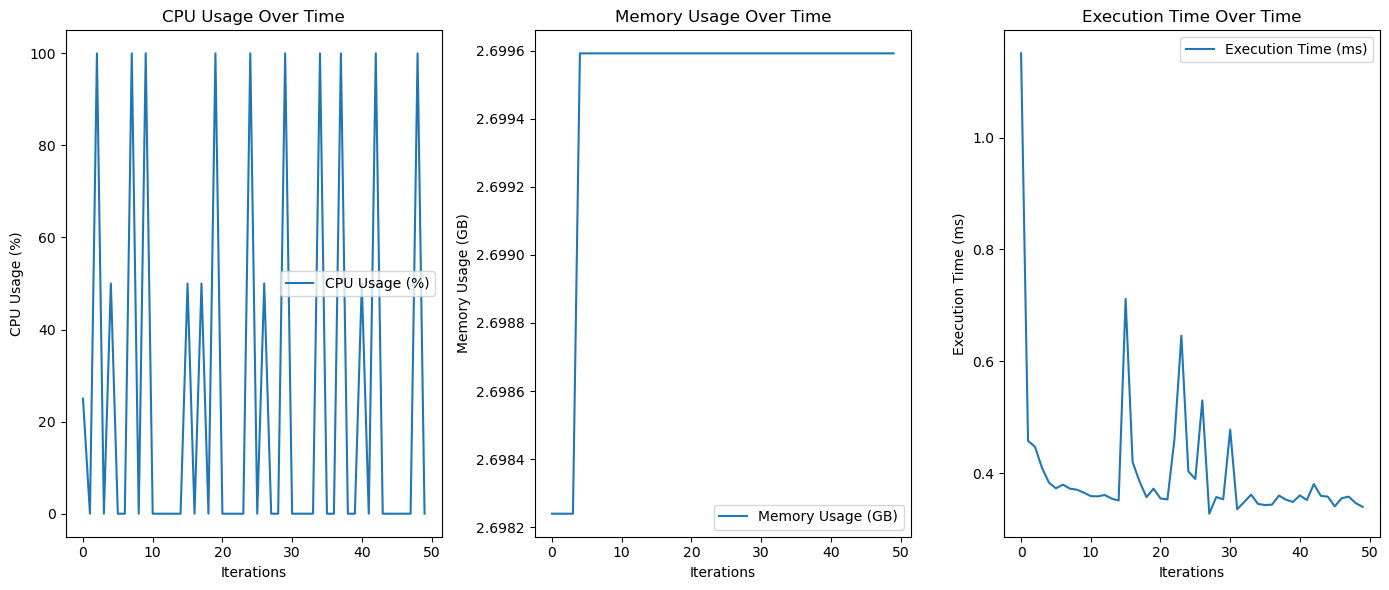

In [24]:
import pandas as pd
import numpy as np
import time
import psutil
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from scipy import spatial
import matplotlib.pyplot as plt

# Function to monitor CPU usage
def monitor_cpu():
    cpu_percent = psutil.cpu_percent(interval=None)
    return cpu_percent

# Function to monitor memory usage
def monitor_memory():
    memory_info = psutil.virtual_memory()
    return memory_info.used # in bytes

# Lists to store performance data
cpu_usages = []
memory_usages = []
execution_times = []

# Measure start time and CPU usage
start_time = time.time()
cpu_usage_start = monitor_cpu()
memory_usage_start = monitor_memory()

# Load preference data
preference_df = pd.read_csv("synthetic-dataset/preference.csv")
user_item_matrix = preference_df.pivot(index='user_id', columns='activity_id', values='preference').fillna(0)

# Adjust preference values
user_item_matrix[user_item_matrix == -1] = np.nan

user_item_matrix.head()

# See how cosine similarity works
a = np.array([0, 2, 4])
b = np.array([1, 4, 2])
a = a - np.mean(a)
b = b - np.mean(b)
a = a / np.linalg.norm(a)
b = b / np.linalg.norm(b)
mat = np.stack((a, b), axis=0)

print(spatial.distance.cosine(a, b))
print(cosine_similarity(mat))

# Replace -1 with NaN to indicate missing data
user_item_matrix.replace(-1, np.nan, inplace=True)

# Fill NaN values with the mean of each user's preferences for the purpose of computing similarities
mean_user_preferences = user_item_matrix.mean(axis=1)
mean_user_preferences = mean_user_preferences.fillna(mean_user_preferences.mean())
user_item_matrix_filled = user_item_matrix.T.fillna(mean_user_preferences).T

# Compute cosine similarity between users
user_similarity_matrix = cosine_similarity(user_item_matrix_filled)

print("Dimensions of user similarity matrix:", user_similarity_matrix.shape)
print("Number of users:", user_similarity_matrix.shape[0])
print("Number of items:", user_item_matrix_filled.shape[1])
print("Length of one row of user item matrix:", len(user_item_matrix_filled.iloc[0]))

# Function to predict preferences
def predict_preferences(user_id):
    # Weights are the similarities with other users
    weights = user_similarity_matrix[user_id]
    # Get the ratings from all users
    ratings = user_item_matrix_filled.values
    # Compute the weighted sum of ratings
    weighted_ratings = np.dot(weights, ratings)
    # Compute the sum of weights
    sum_of_weights = np.array([np.abs(weights).sum() for _ in range(ratings.shape[1])])
    # Predicted preferences
    predicted_preferences = weighted_ratings / sum_of_weights
    # Replace known values with original to not predict them
    predicted_preferences[user_item_matrix.iloc[user_id].notna().values] = user_item_matrix.iloc[user_id].values[user_item_matrix.iloc[user_id].notna().values]
    return predicted_preferences

# Example: predict preferences for user 0
predicted_preferences_user_0 = predict_preferences(0)
print("Predicted preferences for user 0:", predicted_preferences_user_0)

# Predict preferences for all user-item pairs
all_predictions = np.zeros_like(user_item_matrix.values)
for i in range(user_item_matrix.shape[0]):
    start_time_iteration = time.time()
    all_predictions[i, :] = predict_preferences(i)
    # Capture performance metrics
    cpu_usages.append(monitor_cpu())
    memory_usages.append(monitor_memory())
    execution_times.append(time.time() - start_time_iteration)

# Calculate MSE
mse = mean_squared_error(user_item_matrix_filled.values.flatten(), all_predictions.flatten())
print("Mean Squared Error:", mse)

users = pd.read_csv("synthetic-dataset/user.csv")
activities = pd.read_csv("synthetic-dataset/activity.csv", sep='|')
user_id = np.random.choice(users['user_id'])
print("User ID:", user_id)

true_user_condition = users[users['user_id'] == user_id].values[0][1]
print("True user conditions:", true_user_condition)

predicted_preferences = predict_preferences(user_id)
print("Predicted preferences:", predicted_preferences)

# Find the top 5 activities with the highest predicted preferences
top_activities = np.argsort(predicted_preferences)[::-1][:5]
print("Top 5 activities:", top_activities)

# Get the target condition of the top activities
target_conditions = activities.loc[top_activities, 'target_condition'].values
print("Target conditions of top activities:", target_conditions)

# Function to measure custom accuracy
def custom_accuracy(user, prediction):
    # Get the user's condition
    user_condition = users[users['user_id'] == user]['condition_id'].values[0]
    # Get the target condition of the top activities
    top_activities = np.argsort(prediction)[::-1][:5]
    target_conditions = activities.loc[top_activities, 'target_condition'].values
    # Measure the accuracy by summing a coefficient for each suggestion, decreasing with the rank
    accuracy = 0
    for rk, condition in enumerate(target_conditions):
        if condition == user_condition:
            accuracy += 0.5 / 2**rk

    return accuracy

# Get the unique target conditions
unique_conditions = activities['target_condition'].unique()

# Initialize a dictionary to store the MSE for each condition
mse_by_condition = {condition: 0 for condition in unique_conditions}
accuracy_by_condition = {condition: 0 for condition in unique_conditions}

# Iterate over each condition
for condition in unique_conditions:
    # Get the user ids with the target condition
    user_ids = users[users['condition_id'] == condition]['user_id'].values
    # Calculate the MSE for the users with the target condition
    mse_by_condition[condition] = mean_squared_error(user_item_matrix_filled.loc[user_ids].values.flatten(), all_predictions[user_ids].flatten())
    # Calculate the accuracy for the users with the target condition
    for user_id in user_ids:
        accuracy_by_condition[condition] += custom_accuracy(user_id, all_predictions[user_id])
    # Normalize the accuracy
    accuracy_by_condition[condition] /= len(user_ids)

print("MSE by condition:", mse_by_condition)
print("Accuracy by condition:", accuracy_by_condition)

# Measure end time
memory_usage_end = monitor_memory()
end_time = time.time()

# Calculate total execution time and CPU usage
execution_time = end_time - start_time
cpu_usage_average = sum(cpu_usages) / len(cpu_usages)

print(f"Total execution time: {execution_time} seconds")
print(f"CPU usage: {cpu_usage_average}%")
print(f"Memory usage: {(memory_usage_end - memory_usage_start)*1e-6} MB")

# Plotting performance metrics
plt.figure(figsize=(14, 6))

# CPU usage plot
plt.subplot(1, 3, 1)
plt.plot(cpu_usages, label='CPU Usage (%)')
plt.xlabel('Iterations')
plt.ylabel('CPU Usage (%)')
plt.title('CPU Usage Over Time')
plt.legend()

# Memory usage plot
plt.subplot(1, 3, 2)
plt.plot(np.array(memory_usages)*1e-9, label='Memory Usage (GB)')
plt.xlabel('Iterations')
plt.ylabel('Memory Usage (GB)')
plt.title('Memory Usage Over Time')
plt.legend()

# Execution time plot
plt.subplot(1, 3, 3)
plt.plot(np.array(execution_times)*1000, label='Execution Time (ms)')
plt.xlabel('Iterations')
plt.ylabel('Execution Time (ms)')
plt.title('Execution Time Over Time')
plt.legend()

plt.tight_layout()
plt.show()
